In [1]:
import ctypes
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300

from tqdm.auto import tqdm

In [2]:
df_ill = pd.read_csv("../data/ill.csv")
df_normalized = pd.read_csv("../data/normalized.csv")

In [3]:
genes = ['KCNQ1', 'CACNA1C', 'SLC8A1', 'ATP1A1', 'ATP2B4', 'ATP2A2', 'CALM1', 'RYR2']
currents = ["GKs", "PCa", "Gncx", "Pnak", "GpCa", "upScale", "cmdnmax", "Jrel_scaling_factor"]

In [4]:
df = df_ill.loc[genes].copy()

In [5]:
df.index = df.reset_index().iloc[:, 0].replace(dict(zip(genes, currents)))

In [6]:
df

,V1,V2
index,,
GKs,1.135151,0.466996
PCa,0.689786,1.453437
Gncx,1.792116,0.822127
Pnak,0.554626,0.562787
GpCa,0.757819,1.163409
upScale,0.553460,0.450475
cmdnmax,0.773168,0.499590
Jrel_scaling_factor,0.502022,0.560491


# MAIN

In [7]:
dirname = '../../ga/models_ctypes/src/model_ctypes/_ohara_rudy/'
filename_so = os.path.join(dirname, 'model.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')
]
model.run.restype = ctypes.c_int

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')

In [8]:
df["original"] = 1.
df

,V1,V2,original
index,,,
GKs,1.135151,0.466996,1.0
PCa,0.689786,1.453437,1.0
Gncx,1.792116,0.822127,1.0
Pnak,0.554626,0.562787,1.0
GpCa,0.757819,1.163409,1.0
upScale,0.553460,0.450475,1.0
cmdnmax,0.773168,0.499590,1.0
Jrel_scaling_factor,0.502022,0.560491,1.0


In [9]:
plos = {"GK1": 0.283,
        "GKr": 1.,
        "GKs": 0.14,
        "GNa": 2.5,
        "Gto": 9.7,
        "PCa": 0.8,
        "Gncx": 1.8,
        "Pnak": 1.2,
        "GpCa": 0.17,
        "upScale": 2.23,
        "cmdnmax": 3.76,
        "Jrel_scaling_factor": 0.69,
        # "CAMK": 0.21,
        }

In [10]:
def create_output(CL, n_beats, t_sampling, C, S):
    
    C['i_Stim_Period'] = CL
    stim_period = C['i_Stim_Period']
    n_samples_per_stim = int(stim_period / t_sampling)

    output = pd.DataFrame(np.zeros((n_samples_per_stim * n_beats + 1, len(S))),
                          columns=S.index)
    
    return output

In [11]:
results = dict()

CL_list = 250, 20_000
n_beats_list = 1000, 1

tol = 1e-6
t_sampling = 1

for patient in tqdm(df.columns):
    
    S = legend_states.copy()
    C = legend_constants.copy()
    A = legend_algebraic.copy()
    
    for key, value in plos.items():
        C[key] *= value
    
    for i, row in df.iterrows():
        C[i] *= row[patient]
        
    C["GK1"] *= 0.02
        
    C['i_Stim_Amplitude'] = -120
    C['i_Stim_PulseDuration'] = 1
    
    results[patient] = list()
    
    for i, (CL, n_beats) in enumerate(zip(CL_list, n_beats_list)):
        
        if i != 0:
            S = output.iloc[-1].copy()
            
        output = create_output(CL, n_beats, t_sampling, C, S)

        status = model.run(S.values.copy(), C.values.copy(),
                           n_beats, t_sampling, tol, output.values)

        results[patient].append(output.copy())

  0%|          | 0/3 [00:00<?, ?it/s]

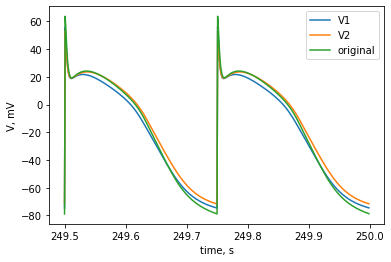

In [12]:
indices = slice(-501, -1)
key = 'v'

i_output = 0

for i, (patient, outputs) in enumerate(results.items()):
    
    output = outputs[i_output]
    waveform = output[key].iloc[indices]
    t = np.arange(len(output))[indices] / 1000
    
    plt.plot(t, waveform, label=patient)
        
plt.legend()
plt.xlabel("time, s")
plt.ylabel("V, mV")

plt.savefig("../images/fig_1.png")

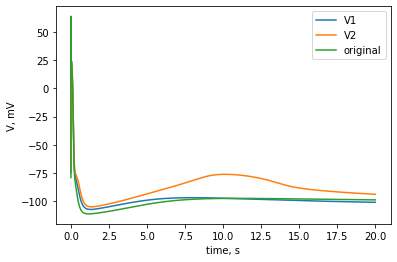

In [13]:
indices = slice(0, -1)
key = 'v'

i_output = 1

for i, (patient, outputs) in enumerate(results.items()):
    
    output = outputs[i_output]
    waveform = output[key].iloc[indices]
    t = np.arange(len(output))[indices] / 1000
    
    plt.plot(t, waveform, label=patient)
        
plt.legend()
plt.xlabel("time, s")
plt.ylabel("V, mV")

plt.savefig("../images/fig_2.png")

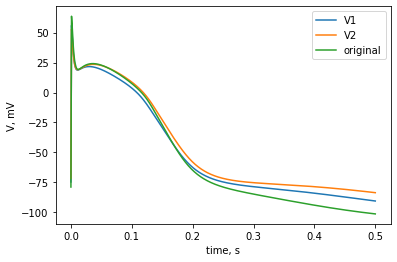

In [14]:
indices = slice(0, 501)
key = 'v'

i_output = 1

for i, (patient, outputs) in enumerate(results.items()):
    
    output = outputs[i_output]
    waveform = output[key].iloc[indices]
    t = np.arange(len(output))[indices] / 1000
    
    plt.plot(t, waveform, label=patient)
        
plt.legend()
plt.xlabel("time, s")
plt.ylabel("V, mV")

plt.savefig("../images/fig_3.png")